## 构建Two-Head网络对OCSVM进行改进

## 数据预处理

In [1]:
import os

import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import visdom
from tqdm import tqdm

from utils import *

# tensorflowGPU的设置

# tf.config.experimental.list_physical_devices('CPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #屏蔽通知信息，输出warning, Error, fatal 

In [2]:
# 加载数据
def judge_1(time):
    time = time[:7].replace('-', '')
    if time <= '201803':
        return True
    else:
        return False

def judge_2(time):
    time = time[:7].replace('-', '')
    if time > '201803':
        return True
    else:
        return False

name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}
data_csv = pd.read_csv('res_handle.csv')
print(data_csv.describe())
data_2017 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2017']
data_2018 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2018']
data_2019 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2019']
# 将201803之前的数据划分到2017数据集下    
data_2018_1 = data_2018[data_2018['first_seen'].apply(judge_1)]
data_2018_2 = data_2018[data_2018['first_seen'].apply(judge_2)]

data_train = data_2017.append(data_2018_1)
data_test_1 = data_2018_2
data_test_2 = data_2019
print("未采样前数据集的规模：", data_train.shape, data_test_1.shape, data_test_2.shape)

# 对测试集进行下采样
data_train = data_train.sample(frac=1, random_state=1).reset_index(drop=True)
data_test_1 = data_test_1.sample(frac=0.7, random_state=1).reset_index(drop=True)
data_test_2 = data_test_2.sample(frac=0.5, random_state=1).reset_index(drop=True)
print("采样后数据集的规模：", data_train.shape, data_test_1.shape, data_test_2.shape)

#获取数据的路径及标签
data_train_names, labels_train = name_loader(data_train)
data_test_1_names, labels_test_1 = name_loader(data_test_1)
data_test_2_names, labels_test_2 = name_loader(data_test_2)

# 利用labelencoder构建opcode编码器
opcode_all = []
for idx in tqdm(range(data_csv.shape[0])):
    opcode_str = data_csv.at[idx, 'opcode'].split()
    opcode_all += opcode_str
    opcode_all = list(set(opcode_all))

le = preprocessing.LabelEncoder()
le.fit(opcode_all)
print(len(list(le.classes_)))

  1%|▏         | 177/12402 [00:00<00:07, 1653.99it/s]

              length
count   12402.000000
mean     5652.612804
std     20251.140030
min         2.000000
25%       202.000000
50%      1105.500000
75%      2849.000000
max    780386.000000
未采样前数据集的规模： (6104, 5) (2642, 5) (3656, 5)
采样后数据集的规模： (6104, 5) (1849, 5) (1828, 5)


100%|██████████| 12402/12402 [00:07<00:00, 1756.97it/s]

641


## 训练two-head模型

In [3]:
# 创建TextCNN类
from tensorflow import keras
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=4,
                 last_activation=None):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))

        # Embedding part can try multichannel as same as origin paper
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [2, 3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)
        d_1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(x)
        d_2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(d_1)

        output_1 = Dense(self.class_num, activation=self.last_activation)(d_2)
        output_2 = Dense(self.class_num, activation=self.last_activation)(d_2)
        model = Model(inputs=input, outputs=[output_1, output_2])
        return model

# 定义工具类函数
def pad_data(res, max_len=2850):
    length = len(res)
    if length > max_len:
        return res[ :max_len]
    elif length < max_len:
        return res + [0]*(max_len-length)
    return res


def train_data_generator(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 5100]
        labels = labels[: 5100]
    elif mode == 'val':    
        codes = codes[5100: ]
        labels = labels[5100: ]

    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]
        
        
def train_data_loader(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 5100]
        labels = labels[: 5100]
    elif mode == 'val':    
        codes = codes[5100: ]
        labels = labels[5100: ]
    
    labels_res = np.eye(4)[labels]
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all), labels_res


def codes_loader(codes):
    
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all)

In [4]:
# 训练
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras

def create_dataset(batch_size=128):
    # 创建训练和验证的dataset对象
    db_train = tf.data.Dataset.from_generator(train_data_generator, args=[data_train_names, labels_train, 'train'], 
                                            output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
    db_val = tf.data.Dataset.from_generator(train_data_generator, args=[data_train_names, labels_train, 'val'], 
                                            output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))

    db_train = db_train.batch(batch_size)
    db_val = db_val.batch(batch_size)

    return db_train, db_val

def train(db_train, db_val, epochs=40):
    # 实例化TextCNN模型
    max_len = 2850
    max_features = 641
    embedding_dims = 16
    model = TextCNN(max_len, max_features, embedding_dims).get_model()

    # 创建训练过程
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss_sup = keras.losses.CategoricalCrossentropy(from_logits=True)
    metrics_train_1 = keras.metrics.CategoricalAccuracy()
    metrics_train_2 = keras.metrics.CategoricalAccuracy()
    metrics_val_1 = keras.metrics.CategoricalAccuracy()
    metrics_val_2 = keras.metrics.CategoricalAccuracy()

    loss_all = []
    acc_all = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        
        for step, (x_batch_train, y_batch_train) in enumerate(db_train):
            with tf.GradientTape() as tape:
                out1, out2 = model(x_batch_train)
                loss_value = loss_sup(y_batch_train, out1) + loss_sup(y_batch_train, out2)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            metrics_train_1(y_batch_train, out1)
            metrics_train_2(y_batch_train, out2)
            
            if step % 10 == 0:
                print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        loss_all.append(loss_value)
        train_acc_1 = metrics_train_1.result()
        train_acc_2 = metrics_train_2.result()
        print('Training acc over epoch: %s %s' % (float(train_acc_1), float(train_acc_2)))
        metrics_train_1.reset_states()
        metrics_train_2.reset_states()
        
        for x_batch_val, y_batch_val in db_val:
            val_out_1, val_out_2 = model(x_batch_val)
            metrics_val_1(y_batch_val, val_out_1)
            metrics_val_2(y_batch_val, val_out_2)
        
        val_acc_1 = metrics_val_1.result()
        val_acc_2 = metrics_val_2.result()
        acc_all.append(val_acc_1)
        print('Validation acc: %s %s' % (float(val_acc_1), float(val_acc_2))) 
        metrics_val_1.reset_states()
        metrics_val_2.reset_states()

    return model, loss_all, acc_all

In [ ]:
db_train, db_val = create_dataset()
model, loss_all, acc_all = train(db_train, db_val)

# 保存模型
model.save('./model/textcnn_twohead_40.h5')

# 绘制损失函数曲线
p1 = plt.figure(figsize=(5, 3.5),dpi=300)
plt.plot(loss_all, label="train")
# plt.plot(acc_all, label="valid")
plt.title("textcnn loss", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xlabel("epoch", fontsize=16)
plt.legend(["train"],loc="upper right")
# plt.legend([], loc="upper right")
plt.savefig("./figures/" + "twohead_loss_40.png")

In [5]:
db_train, db_val = create_dataset()

In [9]:
def get_discs_db(model_twohead, data_tf):
    for step, (x_batch_train, y_batch_train) in enumerate(data_tf):
        out_1, out_2 = model_twohead(x_batch_train)
        out_1 = keras.backend.softmax(out_1).numpy()
        out_2 = keras.backend.softmax(out_2).numpy()
        entropy_1 = np.max(out_1, axis=1)
        entropy_2 = np.max(out_2, axis=1)

        discs_tmp = np.abs(entropy_1 - entropy_2).reshape((-1, 1))
        discs = discs_tmp if step == 0 else np.concatenate([discs, discs_tmp])

    return discs

def get_discs(model, codes_data):
    out_1, out_2 = model_twohead(codes_data)
    out_1 = keras.backend.softmax(out_1).numpy()
    out_2 = keras.backend.softmax(out_2).numpy()

    entropy_1 = np.max(out_1, axis=1)
    entropy_2 = np.max(out_2, axis=1)

    discs = np.abs(entropy_1 - entropy_2).reshape((-1, 1))

    return discs

In [7]:
db_train, db_val = create_dataset()
# 统计所有的discs
%matplotlib inline
import matplotlib.pyplot as plt

epochs_set = [40]
# 计算训练样本的discs
for epochs in epochs_set:#[20, 30, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]:
    print(f"start epochs version: {epochs}")
    max_len = 2850
    max_features = 641
    embedding_dims = 16
    model = TextCNN(max_len, max_features, embedding_dims).get_model()
    model.load_weights('./model/textcnn_twohead_' + str(epochs) + '.h5')

    discs = get_discs(model, db_train)
    df = pd.DataFrame(discs)
    df[0].plot.hist(bins=100, ylabel=None, grid=False, figsize=[10, 7])

start epochs version: 40


<Figure size 2646x1764 with 0 Axes>

In [16]:
discs_list = discs.tolist()
discs_list.sort()
discs_list[5490]

[0.0010448694229125977]

In [26]:
# discs_list = discs.tolist()
# discs_list.sort()
# discs_list[5494]
# df[0].plot.hist(bins=100, grid=False, figsize=[10, 7], fontsize=16)
# tmpfig = df[0].plot.hist(bins=100, grid=False, figsize=[10, 7], fontsize=24)
# tmp_fig = tmpfig.get_figure()
# tmp_fig.savefig("histgram.png", dpi=300)

[0.001066446304321289]

In [9]:
# 查看异常样本的discs
# from tensorflow.keras import Input, Model, regularizers
# from tensorflow import keras
from utils import *
from sklearn.metrics import roc_curve, auc

max_len = 2850
max_features = 641
embedding_dims = 16
model = TextCNN(max_len, max_features, embedding_dims).get_model()
model.load_weights('./model/textcnn_twohead.h5')

data_test_1 = pd.read_csv('data_test_1.csv')
ood_data = data_test_1[data_test_1['id'] == False]
ood2label = {True: 0, False: 1}
labels_test_1 = ood_data['id'].map(lambda x: ood2label[x])
labels_test_1 = labels_test_1.to_list()
names_test_1 = ood_data['name'].to_list()

codes_test_1 = codes_loader(names_test_1)
discs = get_discs(model, codes_test_1)

print(discs.shape)

100%|██████████| 201/201 [00:00<00:00, 204.57it/s]


(201, 1)


In [12]:
from sklearn.metrics import roc_curve, auc, classification_report

def res_testset(data_test, model_split, model_twohead, test_label="2018"):
    ood2label = {True: 0, False: 1}
    labels_test = data_test['id'].map(lambda x: ood2label[x])
    labels_test = labels_test.to_list()
    names_test = data_test['name'].to_list()

    codes_test = codes_loader(names_test)
    labels_test = np.array(labels_test)
    test_auc, discs = get_auc(model, codes_test, labels_test)
    print('Test AUROC: {:.3f}'.format(test_auc))
    # plot_entropy(discs, labels_test, 'entropy_60_test1.png')

    # 确定异常检测阈值
    fpr, tpr, thresholds = roc_curve(labels_test, discs)
    roc_auc = auc(fpr, tpr)

    # 约登指数确定
    index = np.argmax(tpr-fpr)
    print(f"fpr: {fpr[index]}")
    score = thresholds[index]
    print("threshold: ", score)

    # 绘制roc函数曲线
    plt.figure(figsize=(5, 3.5),dpi=300)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', 
            lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr[index], tpr[index], marker='o', color='r')
    plt.text(fpr[index], tpr[index], f'Threshold:{score:.4f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC of two-head on " + test_label + "dataset (TextCNN)")
    plt.legend(loc="lower right")
    plt.show()
    # plt.savefig("./figures/" + "roc_textcnn_60_1.png")

    # 测试异常样本剔除后的准确率
    bool_ = discs < score

    labels_pre_id = data_test['label'].map(lambda x: name2label[x])
    labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
    labels_pre_id = labels_pre_id[bool_]

    model_pre = keras.models.load_model('./model/textcnn_split.h5')
    codes_pre_id = codes_test[bool_.reshape(-1)]
    y_pred = model_pre.predict(codes_pre_id)
    y_pred = np.argmax(y_pred, 1)
    target_names = {'trojan', 'virus', 'worm', 'backdoor'}
    print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))

    # 异常检测准确率
    two_pred = np.array(discs > score)
    two_pred = two_pred.astype('int64')
    ood2label = {True: 0, False: 1}
    label_id = np.array(data_test['id'].map(lambda x: ood2label[x]))
    print(classification_report(label_id, two_pred, digits=4))

100%|██████████| 1849/1849 [00:12<00:00, 148.95it/s]


Test AUROC: 0.933
fpr: 0.055825242718446605
threshold:  0.0023967624


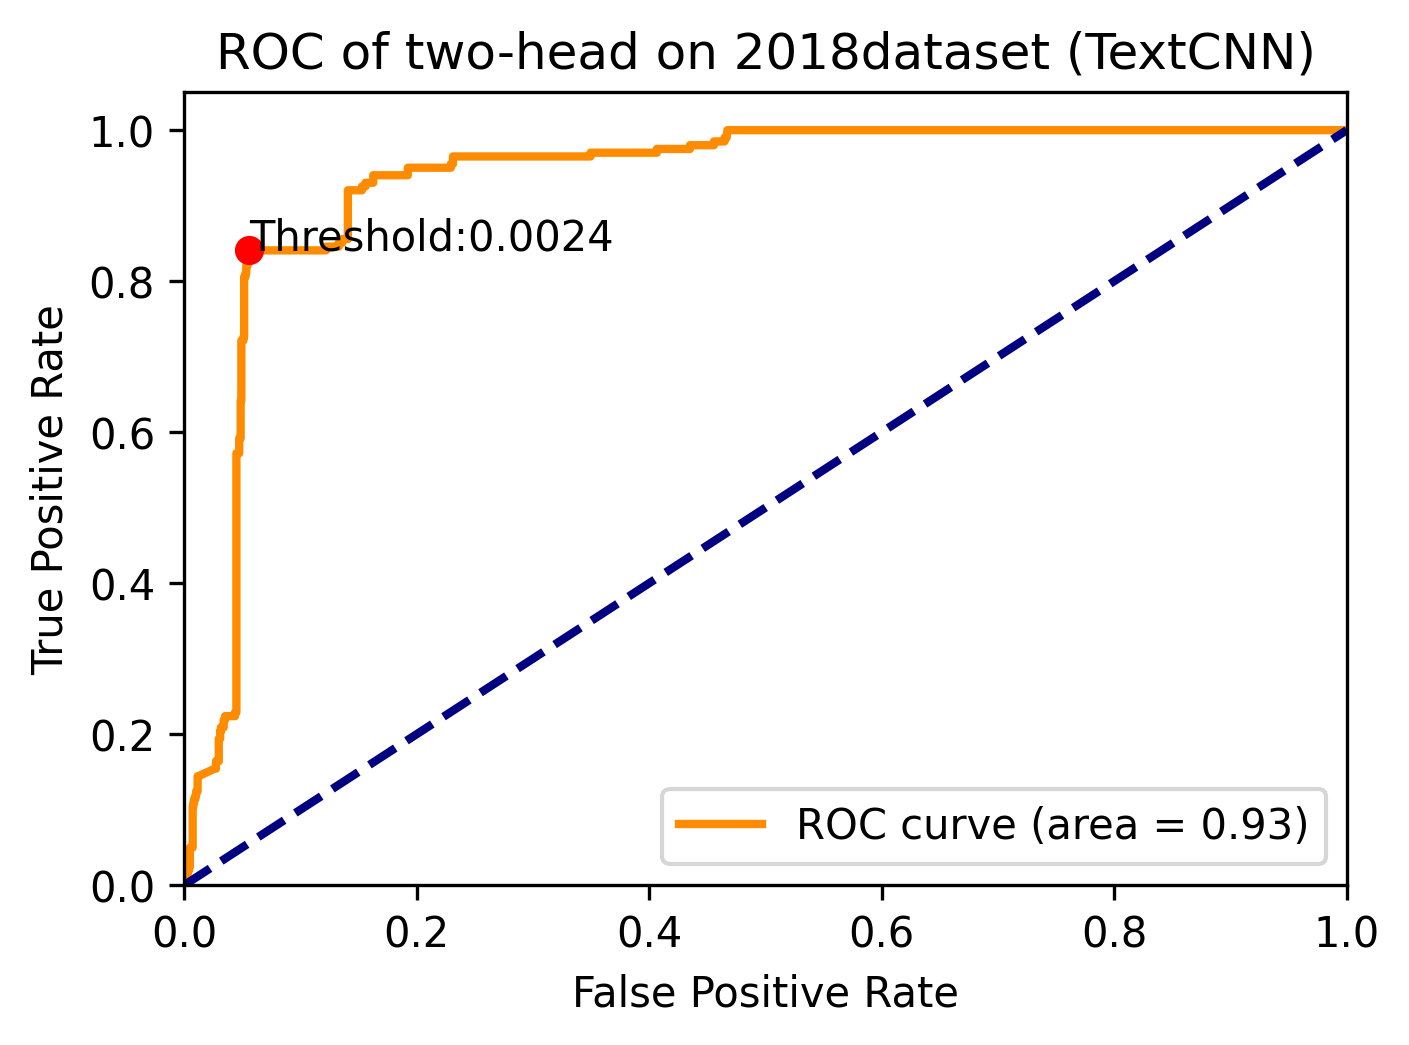

              precision    recall  f1-score   support

        worm     0.9554    0.9860    0.9705       500
    backdoor     0.9925    0.9981    0.9953       532
      trojan     0.9820    0.9820    0.9820       222
       virus     0.9968    0.9401    0.9676       334

    accuracy                         0.9798      1588
   macro avg     0.9817    0.9766    0.9789      1588
weighted avg     0.9803    0.9798    0.9798      1588

              precision    recall  f1-score   support

           0     0.9792    0.9442    0.9614      1648
           1     0.6462    0.8358    0.7289       201

    accuracy                         0.9324      1849
   macro avg     0.8127    0.8900    0.8451      1849
weighted avg     0.9430    0.9324    0.9361      1849



In [13]:
# 计算测试集上的roc相关的数据
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras
from utils import *

max_len = 2850
max_features = 641
embedding_dims = 16
model_twohead = TextCNN(max_len, max_features, embedding_dims).get_model()
model_twohead.load_weights('./model/textcnn_twohead_40.h5')
model_split = keras.models.load_model('./model/textcnn_split.h5')

data_test_1 = pd.read_csv('data_test_1.csv')
data_test_2 = pd.read_csv('data_test_2.csv')
res_testset(data_test_1, model_split, model_twohead, test_label="2018")
res_testset(data_test_2, model_split, model_twohead, test_label="2019")

## 进行参数微调并改进模型

In [32]:
# 自定义损失函数
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras

model = TextCNN(max_len, max_features, embedding_dims).get_model()
class DiscrepancyLoss(keras.losses.Loss):
    def __init__(self, reduction=keras.losses.Reduction.NONE, 
                 from_logits=True, name='membership loss'):
        super().__init__(reduction=reduction, name=name)
    
    def call(self, out1, out2, m=0.3):
        out_1 = K.softmax(out1)
        out_2 = K.softmax(out2)     
        entropy_1 = -out_1 * K.log(out_1)
        entropy_2 = -out_2 * K.log(out_2)
        entropy_1 = K.mean(entropy_1, axis=1)
        entropy_2 = K.mean(entropy_2, axis=1) 
        
        return K.relu(m - K.mean(entropy_1 - entropy_2))

In [25]:
# 加载SVM预测数据
data_test_1 = pd.read_csv('data_test_1.csv')
data_test_unsup = data_test_1[data_test_1['id']==False]
codes_unsup = data_test_unsup['name'].to_list()

In [26]:
data_test_unsup.shape

(201, 7)

In [33]:
def codes_generator(codes):
    
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res

def svmdata_generator(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 522]
        labels = labels[: 522]
    elif mode == 'val':    
        codes = codes[522: 1000]
        labels = labels[522: 1000]
    
    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]

In [37]:
# 准备训练数据
batch_size = 64
sup_train = tf.data.Dataset.from_generator(svmdata_generator, args=[data_test_1_names, labels_test_1, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
sup_train = sup_train.batch(batch_size)

sup_val = tf.data.Dataset.from_generator(svmdata_generator, args=[data_test_1_names, labels_test_1, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
sup_val = sup_val.batch(batch_size)

unsup_train = tf.data.Dataset.from_generator(codes_generator, args=[codes_unsup], output_types=(tf.float32), output_shapes=((None,)))
unsup_train = unsup_train.batch(batch_size)

In [36]:
# 准备测试数据
data_test_1 = pd.read_csv('data_test_1.csv')
ood2label = {True: 0, False: 1}
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = labels_test_1.to_list()
paths_test_1 = data_test_1['name'].to_list()
codes_test_1 = codes_loader(paths_test_1)
labels_test_1 = np.array(labels_test_1)

100%|██████████| 1849/1849 [00:13<00:00, 139.47it/s]


In [38]:
# 开始训练
import visdom

model = TextCNN(max_len, max_features, embedding_dims).get_model()
model.load_weights('./model/textcnn_twohead.h5')
optimizer = keras.optimizers.Adam(learning_rate=0.00005)
loss_sup = keras.losses.CategoricalCrossentropy(from_logits=True)
loss_unsup = DiscrepancyLoss()
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()
vis = visdom.Visdom(server='http://localhost')

print('>> Fine-tune a Model.')
best_auc = 0.
num_epochs = 10
iters = 0
plot_data = {'X': [], 'Y': [], 'legend': ['Sup. Loss', 'Unsup. Loss', 'Tot. Loss']}
for epoch in range(num_epochs):
    for step, batch in enumerate(zip(sup_train, unsup_train)):
        
        (x_batch_train, y_batch_train), (x_batch_train_unsup) = batch
#         print('Start of epoch %d step %d' % (epoch,step))
        with tf.GradientTape() as tape:
            out_1, out_2 = model(x_batch_train)
            loss_sup_value = (loss_sup(y_batch_train, out_1) + loss_sup(y_batch_train, out_2)) / 2
            out_1, out_2 = model(x_batch_train_unsup)
            loss_unsup_value = loss_unsup(out_1, out_2)
            loss_value = loss_sup_value + loss_unsup_value
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # 可视化
        if step % 2 == 0:
            
            loss_sup_value = loss_sup_value.numpy()
            loss_unsup_value = loss_unsup_value.numpy()
            loss_value = loss_value.numpy()
            
            plot_data['X'].append(iters)
            plot_data['Y'].append([
                loss_sup_value, loss_unsup_value, loss_value])
            vis.line(
                X=np.stack([np.array(plot_data['X'])] * len(plot_data['legend']), 1),
                Y=np.array(plot_data['Y']),
                opts={
                    'title': 'Loss over Time',
                    'legend': plot_data['legend'],
                    'xlabel': 'Iterations',
                    'ylabel': 'Loss',
                    'width': 900,
                    'height': 300,
                },
                win=2
            )
        iters += 1 
        
        # 进行验证
        if step % 2 == 0:
            out_1, out_2 = model.predict(codes_test_1)
            out_1 = keras.backend.softmax(out_1).numpy()
            out_2 = keras.backend.softmax(out_2).numpy()
            
            entropy_1 = np.max(out_1, axis=1)
            entropy_2 = np.max(out_2, axis=1)
            
#             entropy_1 = keras.backend.mean(entropy_1, axis=1)
#             entropy_2 = keras.backend.mean(entropy_2, axis=1)
        
            labels = np.array(labels_test_1)
            discs = np.abs(entropy_1 - entropy_2).reshape((-1, 1))
            test_auc = metrics.roc_auc_score(labels, discs)
            print('Test AUROC: {:.3f}'.format(test_auc))
            if test_auc > best_auc:
                best_auc = test_auc
                model.save('./model/twohead_best.h5')

Setting up a new session...


>> Fine-tune a Model.
Test AUROC: 0.916
Test AUROC: 0.925
Test AUROC: 0.920
Test AUROC: 0.917
Test AUROC: 0.866
Test AUROC: 0.927
Test AUROC: 0.926
Test AUROC: 0.926
Test AUROC: 0.923
Test AUROC: 0.917
Test AUROC: 0.901
Test AUROC: 0.855
Test AUROC: 0.839
Test AUROC: 0.788
Test AUROC: 0.731
Test AUROC: 0.676
Test AUROC: 0.664
Test AUROC: 0.626
Test AUROC: 0.581
Test AUROC: 0.543


In [14]:
model.load_weights('./model/twohead_best.h5')

from sklearn import metrics
auc_res, discs = get_auc(model, codes_test_1, labels_test_1)
print('Final AUROC: {:.3f}'.format(auc_res))
plot_entropy(discs, labels_test_1, 'entropy_distribution_1.png')

Final AUROC: 0.934


In [15]:
max_len = 2850
max_features = 641
embedding_dims = 16
model = TextCNN(max_len, max_features, embedding_dims).get_model()
model.load_weights('./model/twohead_best.h5')

data_test_1 = pd.read_csv('data_test_1.csv')
ood2label = {True: 0, False: 1}
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = labels_test_1.to_list()
names_test_1 = data_test_1['name'].to_list()

codes_test_1 = codes_loader(data_test_1_names)
labels_test_1 = np.array(labels_test_1)
test_1_auc, discs_1 = get_auc(model, codes_test_1, labels_test_1)
print('Test AUROC: {:.3f}'.format(test_1_auc))
plot_entropy(discs_1, labels_test_1, 'entropy_finetune_test1.png')

data_test_2 = pd.read_csv('data_test_2.csv')
ood2label = {True: 0, False: 1}
labels_test_2 = data_test_2['id'].map(lambda x: ood2label[x])
labels_test_2 = labels_test_2.to_list()
paths_test_2 = data_test_2['name'].to_list()
codes_test_2 = codes_loader(data_test_2_names)
labels_test_2 = np.array(labels_test_2)
test_1_auc, discs_2 = get_auc(model, codes_test_2, labels_test_2)
print('Test AUROC: {:.3f}'.format(test_1_auc))
plot_entropy(discs_2, labels_test_2, 'entropy_finetune_test2.png')

100%|██████████| 1849/1849 [00:12<00:00, 142.42it/s]


Test AUROC: 0.934


100%|██████████| 1828/1828 [00:07<00:00, 247.10it/s]


Test AUROC: 0.857


fpr: 0.19174757281553398
score_1:  0.0013211966


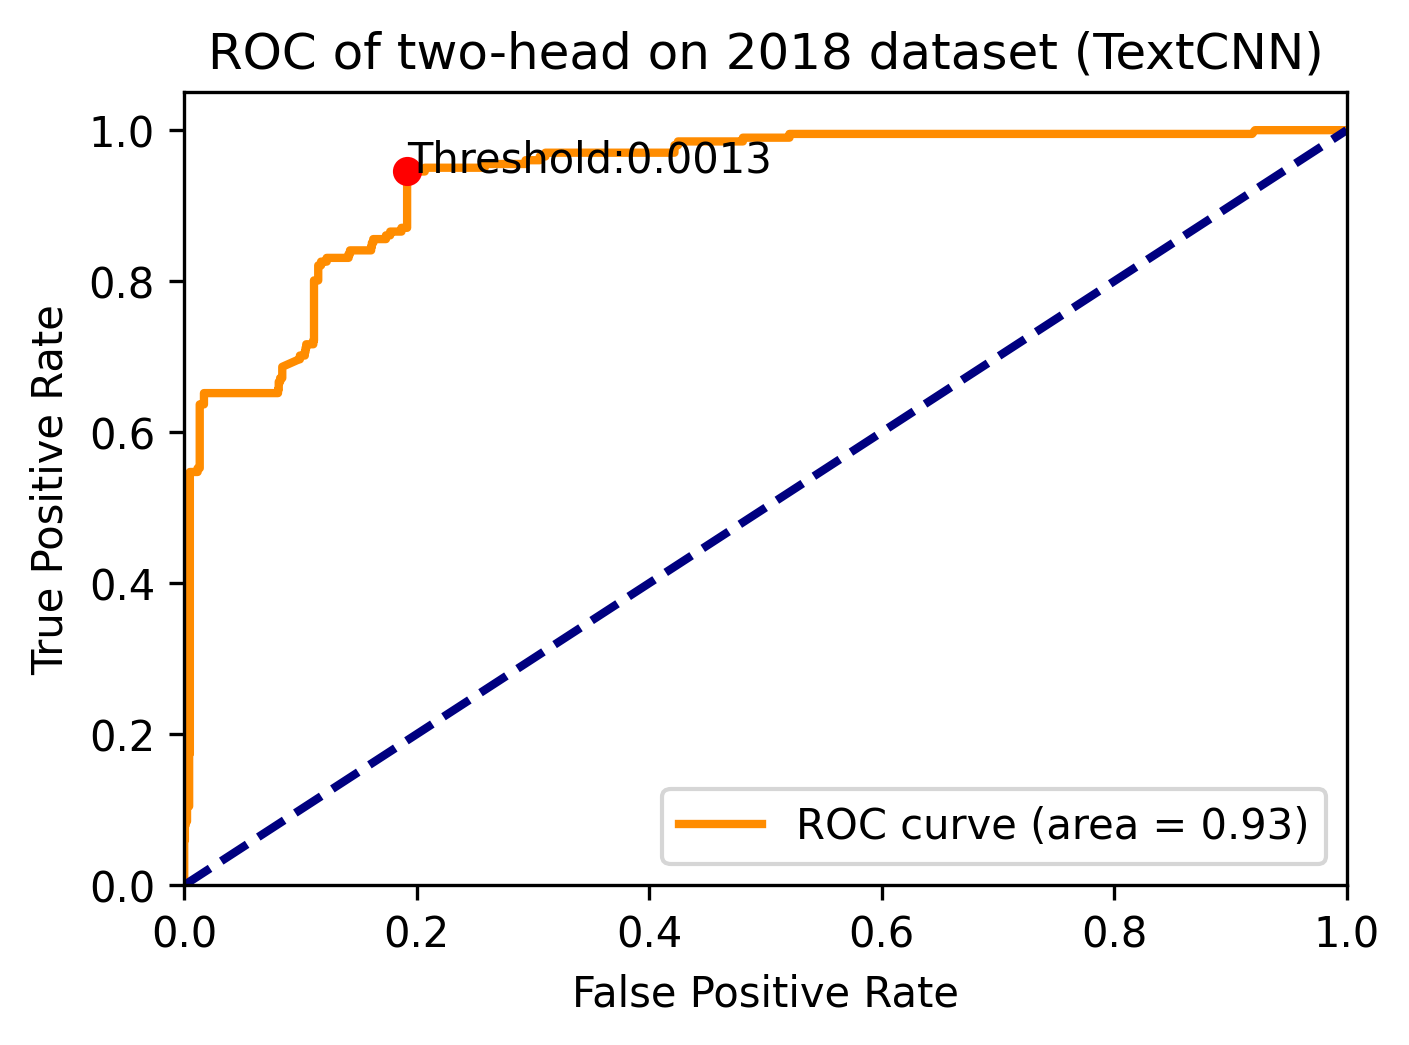

fpr: 0.10980662983425414
score_2:  0.02475965


<Figure size 432x288 with 0 Axes>

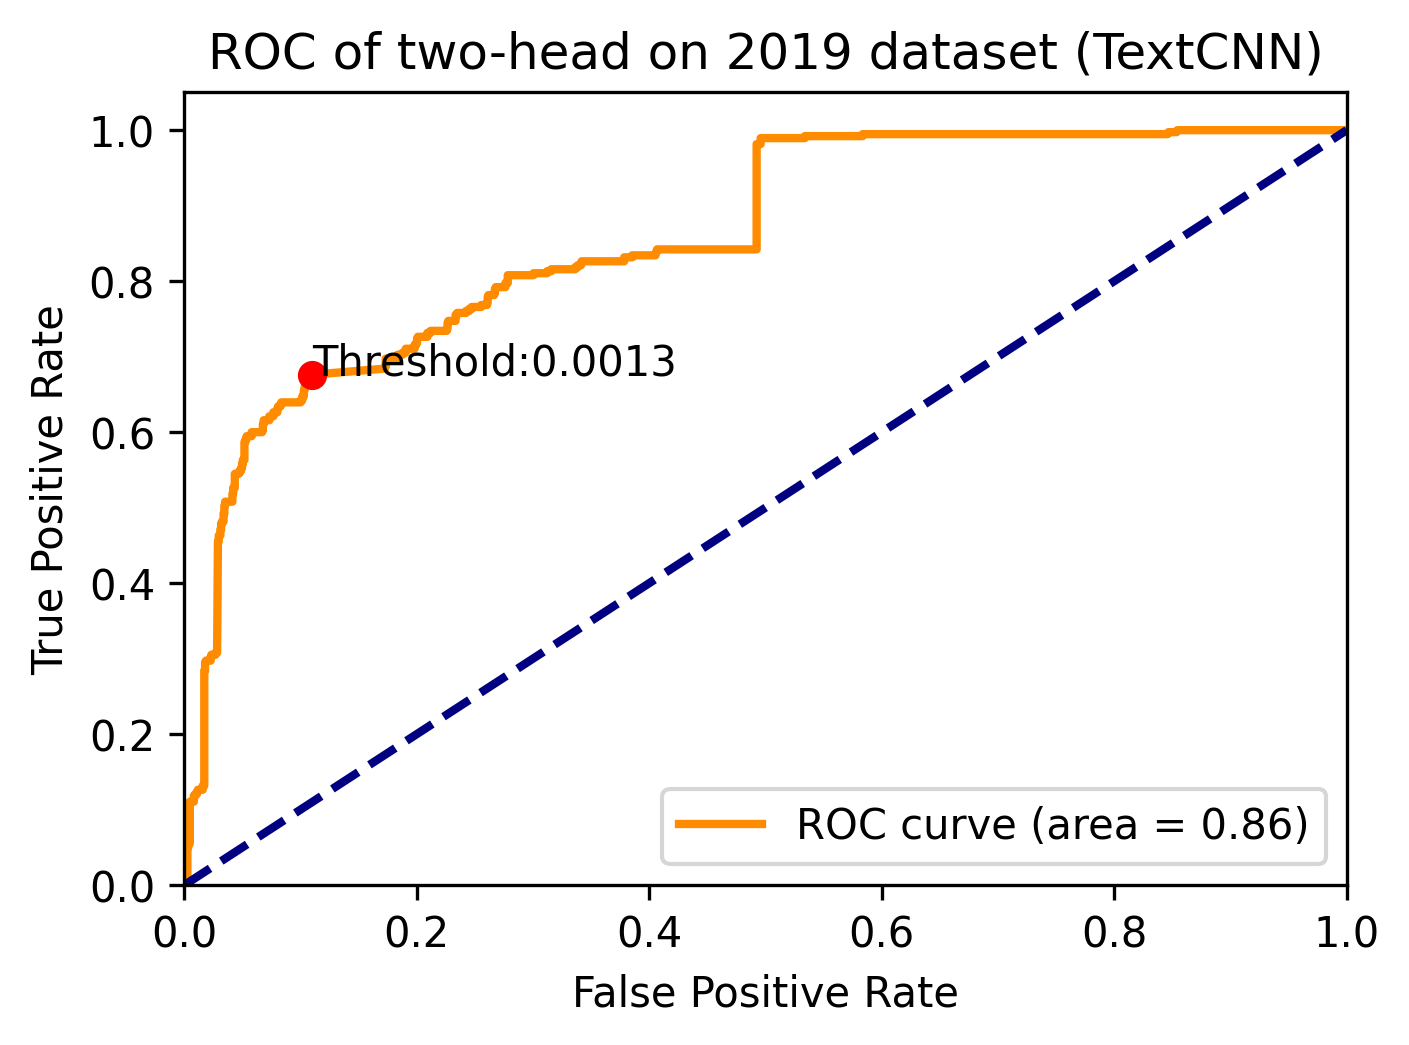

<Figure size 432x288 with 0 Axes>

In [16]:
from sklearn.metrics import roc_curve, auc

# 确定异常检测阈值
fpr, tpr, thresholds = roc_curve(labels_test_1, discs_1)
roc_auc = auc(fpr, tpr)
# for i in range(len(fpr)):
#     if fpr[i] + tpr[i] >= 1:
#         i = i - 1
#         break
# print(fpr[i])
# score_1 = thresholds[i]
# print("score_1: ", score_1)

# 约登指数确定
index = np.argmax(tpr-fpr)
print(f"fpr: {fpr[index]}")
score_1 = thresholds[index]
print("score_1: ", score_1)


bool_1 = discs_1 < score_1

# 绘制roc函数曲线
plt.figure(figsize=(5, 3.5),dpi=300)
lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr[index], tpr[index], marker='o', color='r')
plt.text(fpr[index], tpr[index], f'Threshold:{score_1:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC of two-head on 2018 dataset (TextCNN)")
plt.legend(loc="lower right")
plt.show()
plt.savefig("./figures/" + "roc_textcnn_fine_1.png")

fpr, tpr, thresholds = roc_curve(labels_test_2, discs_2)
roc_auc = auc(fpr, tpr)
# for i in range(len(fpr)):
#     if fpr[i] + tpr[i] >= 1:
#         i = i - 1
#         break
# print(fpr[i])
# score_2 = thresholds[i]
# print("score_2: ", score_2)

index = np.argmax(tpr-fpr)
print(f"fpr: {fpr[index]}")
score_2 = thresholds[index]
print("score_2: ", score_2)

bool_2 = discs_2 < score_2

# 绘制roc函数曲线
plt.figure(figsize=(5, 3.5),dpi=300)
lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr[index], tpr[index], marker='o', color='r')
plt.text(fpr[index], tpr[index], f'Threshold:{score_1:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC of two-head on 2019 dataset (TextCNN)")
plt.legend(loc="lower right")
plt.show()
plt.savefig("./figures/" + "roc_textcnn_fine_2.png")

In [17]:
from sklearn.metrics import classification_report

# 测试异常样本剔除后的准确率
labels_pre_id = data_test_1['label'].map(lambda x: name2label[x])
labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
labels_pre_id = labels_pre_id[discs_1 < score_1]

model_pre = keras.models.load_model('./model/textcnn_split.h5')
bool_code = discs_1 < score_1
codes_pre_id = codes_test_1[bool_code.reshape(-1)]
y_pred = model_pre.predict(codes_pre_id)
y_pred = np.argmax(y_pred, 1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))

# 异常检测准确率
two_pred_1 = np.array(discs_1 > score_1)
two_pred_1 = two_pred_1.astype('int64')
ood2label = {True: 0, False: 1}
label_id_1 = np.array(data_test_1['id'].map(lambda x: ood2label[x]))
print(classification_report(label_id_1, two_pred_1, digits=4))


labels_pre_id = data_test_2['label'].map(lambda x: name2label[x])
labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
labels_pre_id = labels_pre_id[discs_2 < score_2]

model_pre = keras.models.load_model('./model/textcnn_split.h5')
bool_code = discs_2 < score_2
codes_pre_id = codes_test_2[bool_code.reshape(-1)]
y_pred = model_pre.predict(codes_pre_id)
y_pred = np.argmax(y_pred, 1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))

# 异常检测准确率
two_pred_2 = np.array(discs_2 > score_2)
two_pred_2 = two_pred_2.astype('int64')
ood2label = {True: 0, False: 1}
label_id_2 = np.array(data_test_2['id'].map(lambda x: ood2label[x]))
print(classification_report(label_id_2, two_pred_2, digits=4))

              precision    recall  f1-score   support

       virus     0.9853    0.9941    0.9897       338
    backdoor     0.9918    1.0000    0.9959       483
        worm     0.9901    1.0000    0.9950       201
      trojan     1.0000    0.9720    0.9858       321

    accuracy                         0.9918      1343
   macro avg     0.9918    0.9915    0.9916      1343
weighted avg     0.9919    0.9918    0.9918      1343

              precision    recall  f1-score   support

           0     0.9809    0.8083    0.8862      1648
           1     0.3564    0.8706    0.5058       201

    accuracy                         0.8150      1849
   macro avg     0.6686    0.8394    0.6960      1849
weighted avg     0.9130    0.8150    0.8449      1849

              precision    recall  f1-score   support

       virus     0.8707    0.8397    0.8549       393
    backdoor     0.8487    0.9539    0.8982       347
        worm     0.9645    0.8979    0.9300       333
      trojan     0.98

1828
1828


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

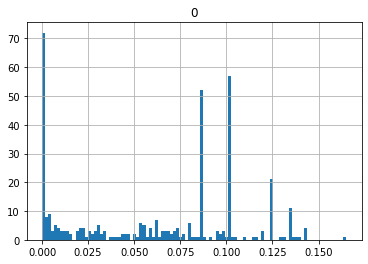

In [24]:
print(len(discs_2))
print(len(label_id_2))
discs_tmp = []
for idx in range(len(discs_2)):
    if label_id_2[idx] == 1:
        discs_tmp.append(discs_2[idx])
tmp = pd.DataFrame(discs_tmp)
tmp.hist(bins=100)